#### Explainability of BERT using LIME

In [1]:
import os
import sys

if "google.colab" in sys.modules:
    workspace_dir = '/content/spam-detection'
    branch = 'master'
    current_dir = os.getcwd()
    if not os.path.exists(workspace_dir) and current_dir != workspace_dir:
        !git clone https://github.com/RationalEar/spam-detection.git
        os.chdir(workspace_dir)
        !git checkout $branch
        !ls -al
        !pip install -q transformers==4.48.0 scikit-learn pandas numpy spacy lime
        !pip install -q torch --index-url https://download.pytorch.org/whl/cu126
        !pip install captum --no-deps --ignore-installed
    else:
        os.chdir(workspace_dir)
        !git pull origin $branch

    from google.colab import drive
    drive.mount('/content/drive')

Cloning into 'spam-detection'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 468 (delta 70), reused 83 (delta 38), pack-reused 331 (from 1)
Receiving objects: 100% (468/468), 7.39 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (228/228), done.
Branch 'feature/explainability-timing' set up to track remote branch 'feature/explainability-timing' from 'origin'.
Switched to a new branch 'feature/explainability-timing'
total 76
drwxr-xr-x 11 root root 4096 Aug 13 10:21 .
drwxr-xr-x  1 root root 4096 Aug 13 10:21 ..
-rw-r--r--  1 root root  584 Aug 13 10:21 docker-compose.yml
-rw-r--r--  1 root root  879 Aug 13 10:21 Dockerfile
-rw-r--r--  1 root root   92 Aug 13 10:21 .dockerignore
drwxr-xr-x  2 root root 4096 Aug 13 10:21 docs
drwxr-xr-x  2 root root 4096 Aug 13 10:21 explainability
drwxr-xr-x  8 root root 4096 Aug 13 10:21 .git
-rw-r--r--  1 root root   38 Aug 13 10:21 .gitignore
drw

In [2]:
import os
import torch

import pandas as pd
from utils.constants import DATA_PATH, MODEL_SAVE_PATH

DATA_PATH

'/content/drive/MyDrive/Projects/spam-detection-data'

In [3]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200
pretrained_embeddings = None

In [5]:
from models.bert import SpamBERT
from transformers import BertTokenizer

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = SpamBERT(dropout=0.2)

# Load the trained model weights
model_path = os.path.join(MODEL_SAVE_PATH, 'spam_bert_final.pt')
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

SpamBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [6]:
from models.bert import tokenize_texts

# Tokenize test data
X_test_input_ids, X_test_attention_mask = tokenize_texts(test_df['text'].tolist(), tokenizer)
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_input_ids = X_test_input_ids.to(device)
X_test_attention_mask = X_test_attention_mask.to(device)
y_test_tensor = y_test_tensor.to(device)

print(f"Test data prepared: {X_test_input_ids.shape[0]} samples")

Test data prepared: 606 samples


In [7]:
# Get model predictions using BERT tokenized inputs
with torch.no_grad():
    model_output = model(
        input_ids=X_test_input_ids,
        attention_mask=X_test_attention_mask
    )
    # If model returns a tuple, use the first element (typically the predictions)
    if isinstance(model_output, tuple):
        y_pred_probs = model_output[0]
    else:
        y_pred_probs = model_output

    y_pred = (y_pred_probs > 0.5).float()

print(f"Model predictions computed for {len(y_pred)} samples")
print(f"Predicted spam samples: {(y_pred == 1).sum().item()}")
print(f"Predicted ham samples: {(y_pred == 0).sum().item()}")

Model predictions computed for 606 samples
Predicted spam samples: 194
Predicted ham samples: 412


In [8]:
samples = (150, 357, 402 , 416, 417, 604)
# display elements in the test set with the given indices
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"


#### LIME for BERT

In [9]:
# Import our BERT LIME explainer
from explainability.BertLimeExplainer import BertLimeExplainer

# Initialize the BERT LIME explainer
lime_explainer = BertLimeExplainer(model, tokenizer, device)

print("BERT LIME Explainer initialized successfully!")

BERT LIME Explainer initialized successfully!


In [10]:
# Display sample texts for LIME analysis
sample_texts = sample_df['text'].tolist()
sample_subjects = sample_df['subject'].tolist()
sample_labels = sample_df['label'].tolist()

print("Sample texts for LIME explanation quality analysis:")
print("=" * 60)
for i, (text, label, subject) in enumerate(zip(sample_texts, sample_labels, sample_subjects)):
    print(f"\nSample {i+1} (Label: {'Spam' if label == 1 else 'Ham'}):")
    print(f"Text: {subject}")

print(f"\nWe will evaluate LIME explanation quality metrics for these {len(sample_texts)} samples.")

Sample texts for LIME explanation quality analysis:

Sample 1 (Label: Ham):
Text: Seeing is believing

Sample 2 (Label: Ham):
Text: Apple Store eNews : November 2002

Sample 3 (Label: Ham):
Text: RE: [ILUG] NVIDIA and Debian Woody

Sample 4 (Label: Spam):
Text: The Flight to Safety is Upon Us

Sample 5 (Label: Spam):
Text: Low cost quality conference calls

Sample 6 (Label: Spam):
Text: Cannabis Difference

We will evaluate LIME explanation quality metrics for these 6 samples.


In [11]:
# Test LIME functionality with a simple example first
print("Testing LIME functionality with a simple example...")

# Use a simple test text
test_text = "This is a simple test message to verify LIME works correctly."

try:
    # Test the prediction function first
    test_prob = lime_explainer._predict_proba([test_text])
    print(f"Test prediction: {test_prob}")

    # Test LIME explanation with minimal parameters
    print("Testing LIME explanation...")
    feature_importance, prediction_prob = lime_explainer.explain_instance(
        test_text,
        num_features=5,
        num_samples=100  # Reduced for testing
    )

    print(f"Test successful! Prediction: {prediction_prob:.4f}")
    print("Feature importance:")
    for word, importance in feature_importance:
        print(f"  {word}: {importance:.4f}")

except Exception as e:
    print(f"Test failed with error: {e}")
    print("This needs to be fixed before proceeding with full analysis.")

print("Test complete.")

Testing LIME functionality with a simple example...
Test prediction: [[0.87242614 0.12757386]]
Testing LIME explanation...
Test successful! Prediction: 0.1276
Feature importance:
  is: 0.0055
  a: 0.0029
  simple: 0.0026
  correctly: 0.0023
  This: 0.0020
Test complete.


In [12]:
# Demonstrate basic LIME explanation for the first sample
explanation_times = []
for i in samples:
    selected_text = test_df['text'].iloc[i]
    selected_subject = test_df['subject'].iloc[i]
    selected_label = 'Spam' if test_df['label'].iloc[i] == 1 else 'Ham'

    print(f"Demonstrating LIME explanation for Sample 1 ({selected_label}):")
    print(f"Subject: {selected_subject}")
    print("\n" + "="*60)

    # Generate LIME explanation
    print("Generating LIME explanation...")
    start_time = pd.Timestamp.now()
    feature_importance, prediction_prob = lime_explainer.explain_instance(
        selected_text,
        num_features=10,
        num_samples=100
    )
    end_time = pd.Timestamp.now()
    prediction_time = end_time - start_time
    explanation_times.append(prediction_time.total_seconds())
    print(f"\nModel prediction probability (spam): {prediction_prob:.4f}")
    print(f"Predicted class: {'Spam' if prediction_prob > 0.5 else 'Ham'} ({prediction_time})")

    print("\nTop 10 most important features:")
    print("-" * 40)
    for j, (word, importance) in enumerate(feature_importance, 1):
        direction = "→ Spam" if importance > 0 else "→ Ham"
        print(f"{j:2d}. {word:15s} {importance:8.4f} {direction}")


Demonstrating LIME explanation for Sample 1 (Ham):
Subject: Seeing is believing

Generating LIME explanation...

Model prediction probability (spam): 0.0478
Predicted class: Ham (0 days 00:00:01.411940)

Top 10 most important features:
----------------------------------------
 1. author           -0.0010 → Ham
 2. believing        -0.0009 → Ham
 3. paris             0.0007 → Spam
 4. seeing           -0.0006 → Ham
 5. she              -0.0006 → Ham
 6. url              -0.0006 → Ham
 7. until            -0.0005 → Ham
 8. what             -0.0004 → Ham
 9. URL              -0.0002 → Ham
10. grant            -0.0001 → Ham
Demonstrating LIME explanation for Sample 1 (Ham):
Subject: Apple Store eNews : November 2002

Generating LIME explanation...

Model prediction probability (spam): 0.0505
Predicted class: Ham (0 days 00:00:01.444687)

Top 10 most important features:
----------------------------------------
 1. visit            -0.0014 → Ham
 2. want              0.0012 → Spam
 3. our   

In [13]:
# create explanation time data frame
explanation_time_df = pd.DataFrame(explanation_times)
explanation_time_df.describe()

,0
count,6.000000
mean,2.612296
std,2.414773
min,1.411940
25%,1.439011
50%,1.510530
75%,2.128169
max,7.491557


In [14]:
# Compute explanation quality metrics for all samples
print("Computing LIME explanation quality metrics for all samples...")
print("=" * 60)

lime_results = []
explanation_metrics_time = []
for i, (text, subject) in enumerate(zip(sample_texts,sample_subjects)):
    print(f"\nProcessing Sample {i+1}:")
    print(f"Subject: {subject}")

    try:
        # Compute metrics using LIME
        start_time = pd.Timestamp.now()
        metrics = lime_explainer.evaluate_explanation_quality(
            text,
            verbose=True
        )
        end_time = pd.Timestamp.now()
        prediction_time = (end_time - start_time).total_seconds()
        explanation_metrics_time.append(prediction_time)
        metrics['sample_id'] = i + 1
        metrics['text'] = subject
        metrics['label'] = sample_labels[i]
        metrics['method'] = 'LIME'
        metrics['time'] = prediction_time

        lime_results.append(metrics)

    except Exception as e:
        print(f"Error processing sample {i+1}: {e}")
        continue

print(f"\nCompleted processing {len(lime_results)} samples with LIME.")

Computing LIME explanation quality metrics for all samples...

Processing Sample 1:
Subject: Seeing is believing
Evaluating LIME explanation quality for text: 'seeing believing url <URL> author linda grant neve...'
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...

LIME EXPLANATION QUALITY METRICS
AUC-Deletion:     0.2040 (lower is better)
AUC-Insertion:    0.0513 (higher is better)
Comprehensiveness: 0.0075 (higher is better)
Jaccard Stability: 0.3810 (higher is better)

Timing Information:
AUC-Deletion Time: 1.55 seconds
AUC-Insertion Time: 1.58 seconds
Comprehensiveness Time: 1.44 seconds
Jaccard Stability Time: 15.71 seconds
Total Time: 20.28 seconds

Processing Sample 2:
Subject: Apple Store eNews : November 2002
Evaluating LIME explanation quality for text: 'apple store enews november 2002 you appear using e...'
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...

LIME EXPLAN

In [15]:
# create explanation time data frame
explanation_metrics_time_df = pd.DataFrame(explanation_metrics_time)
explanation_metrics_time_df.describe()

,0
count,6.000000
mean,37.278795
std,33.837849
min,20.280147
25%,20.940599
50%,22.017978
75%,30.320226
max,105.687550


In [16]:
# Create comprehensive results summary
import pandas as pd

if lime_results:
    # Convert results to DataFrame for better visualization
    lime_df = pd.DataFrame(lime_results)

    print("COMPREHENSIVE LIME EXPLANATION QUALITY RESULTS")
    print("=" * 60)

    # Summary statistics
    summary_stats = lime_df[['auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability']].agg(['mean', 'std', 'min', 'max'])
    print("\nSummary Statistics:")
    print(summary_stats)

    # Detailed results by sample
    print("\nDetailed Results by Sample:")
    display_cols = ['sample_id', 'auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability', 'label', 'time']
    print(lime_df[display_cols].to_string(index=False))

    # Analysis by label (Spam vs Ham)
    print("\nResults by Label:")
    label_stats = lime_df.groupby('label')[['auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability']].mean()
    label_stats.index = ['Ham', 'Spam']
    print(label_stats)

    # Quality assessment
    print("\nQuality Assessment:")
    print("-" * 30)

    # Good explanations should have:
    # - Low AUC-Del (< 0.5 is good)
    # - High AUC-Ins (> 0.5 is good)
    # - High Comprehensiveness (> 0.1 is good)
    # - High Jaccard Stability (> 0.5 is good)

    good_auc_del = (lime_df['auc_deletion'] < 0.5).sum()
    good_auc_ins = (lime_df['auc_insertion'] > 0.5).sum()
    good_comprehensiveness = (lime_df['comprehensiveness'] > 0.1).sum()
    good_jaccard = (lime_df['jaccard_stability'] > 0.5).sum()

    total_samples = len(lime_df)

    print(f"Samples with good AUC-Deletion (< 0.5):     {good_auc_del}/{total_samples} ({good_auc_del/total_samples*100:.1f}%)")
    print(f"Samples with good AUC-Insertion (> 0.5):    {good_auc_ins}/{total_samples} ({good_auc_ins/total_samples*100:.1f}%)")
    print(f"Samples with good Comprehensiveness (> 0.1): {good_comprehensiveness}/{total_samples} ({good_comprehensiveness/total_samples*100:.1f}%)")
    print(f"Samples with good Jaccard Stability (> 0.5): {good_jaccard}/{total_samples} ({good_jaccard/total_samples*100:.1f}%)")

else:
    print("No results available for analysis.")

COMPREHENSIVE LIME EXPLANATION QUALITY RESULTS

Summary Statistics:
      auc_deletion  auc_insertion  comprehensiveness  jaccard_stability
mean      0.511271       0.507129           0.007028           0.124339
std       0.454179       0.486366           0.012757           0.143391
min       0.048439       0.051055           0.000157           0.000000
max       0.955380       0.955827           0.032433           0.380952

Detailed Results by Sample:
 sample_id  auc_deletion  auc_insertion  comprehensiveness  jaccard_stability  label       time
         1      0.203971       0.051314           0.007507           0.380952      0  20.280147
         2      0.048439       0.087612           0.001132           0.176190      0  20.893969
         3      0.051301       0.051055           0.000157           0.000000      0  32.775145
         4      0.954524       0.954841           0.000363           0.047222      1  22.955469
         5      0.854009       0.942124           0.032433     

Visualizing LIME deletion and insertion curves for Sample 1 (Ham):
Subject: Seeing is believing

Plotting deletion and insertion curves for LIME explanations:


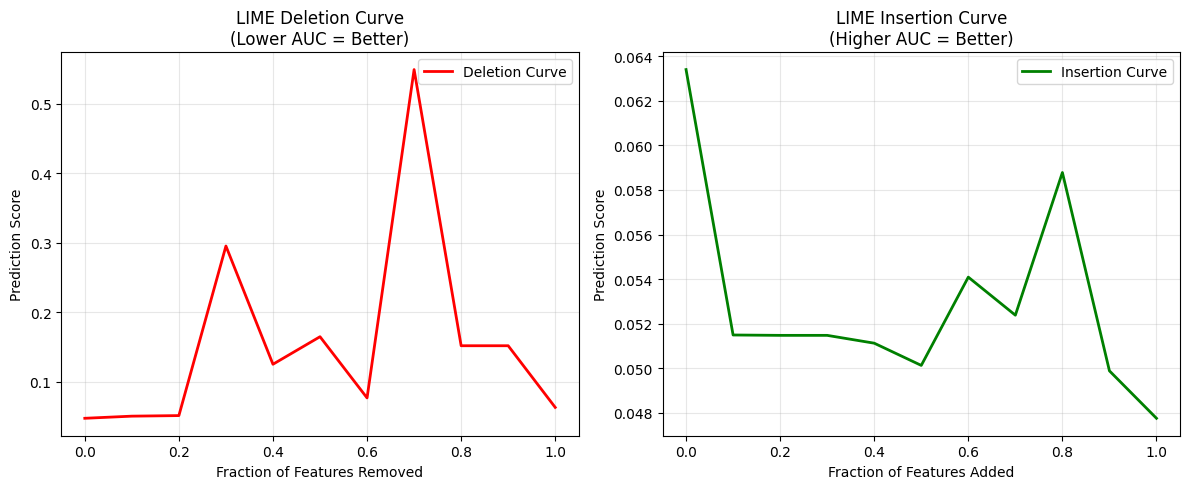

In [17]:
# Visualize deletion and insertion curves for the first sample
if sample_texts:
    selected_text = sample_texts[0]
    selected_subject = sample_subjects[0]
    selected_label = 'Spam' if sample_labels[0] == 1 else 'Ham'

    print(f"Visualizing LIME deletion and insertion curves for Sample 1 ({selected_label}):")
    print(f"Subject: {selected_subject}")
    print("\n" + "="*60)

    # Plot curves for LIME
    print("Plotting deletion and insertion curves for LIME explanations:")
    lime_explainer.plot_deletion_insertion_curves(
        selected_text,
        steps=20
    )

else:
    print("No sample texts available for visualization.")

In [18]:
# Compare LIME results with other explanation methods (if available)
print("Comparison with Other Explanation Methods")
print("=" * 60)

# Try to load results from BERT_Explain.ipynb if available
try:
    import os
    results_dir = os.path.join(DATA_PATH, 'results', 'explanation_quality')

    # Look for existing results files
    bert_ig_file = os.path.join(results_dir, 'bert_explanation_quality_metrics.csv')
    bert_ig_alt_file = os.path.join(results_dir, 'bert_ig_metrics.csv')

    comparison_df = None

    if os.path.exists(bert_ig_file):
        bert_results = pd.read_csv(bert_ig_file)
        print(f"Loaded BERT Integrated Gradients results from: {bert_ig_file}")

        # Combine with LIME results for comparison
        if lime_results:
            lime_df_comparison = lime_df.copy()
            comparison_df = pd.concat([bert_results, lime_df_comparison], ignore_index=True)

    elif os.path.exists(bert_ig_alt_file):
        bert_results = pd.read_csv(bert_ig_alt_file)
        print(f"Loaded BERT Integrated Gradients results from: {bert_ig_alt_file}")

        if lime_results:
            lime_df_comparison = lime_df.copy()
            comparison_df = pd.concat([bert_results, lime_df_comparison], ignore_index=True)

    if comparison_df is not None:
        print("\nComparison of Explanation Methods:")
        method_comparison = comparison_df.groupby('method')[['auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability']].agg(['mean', 'std'])
        print(method_comparison)

        # Create a more readable comparison
        print("\nMethod Performance Summary:")
        print("-" * 40)
        for method in comparison_df['method'].unique():
            method_data = comparison_df[comparison_df['method'] == method]
            print(f"\n{method}:")
            print(f"  AUC-Deletion (lower=better):     {method_data['auc_deletion'].mean():.4f} ± {method_data['auc_deletion'].std():.4f}")
            print(f"  AUC-Insertion (higher=better):   {method_data['auc_insertion'].mean():.4f} ± {method_data['auc_insertion'].std():.4f}")
            print(f"  Comprehensiveness (higher=better): {method_data['comprehensiveness'].mean():.4f} ± {method_data['comprehensiveness'].std():.4f}")
            print(f"  Jaccard Stability (higher=better): {method_data['jaccard_stability'].mean():.4f} ± {method_data['jaccard_stability'].std():.4f}")
    else:
        print("No previous explanation results found for comparison.")
        print("Run BERT_Explain.ipynb first to generate comparison data.")

except Exception as e:
    print(f"Could not load comparison data: {e}")
    print("LIME results are available independently.")

Comparison with Other Explanation Methods
No previous explanation results found for comparison.
Run BERT_Explain.ipynb first to generate comparison data.


### Interpretation of LIME Explanation Quality Metrics

The explanation quality metrics provide insights into how well LIME explanations perform for our BERT model:

#### **1. AUC-Del (Area Under Deletion Curve)**
- **Lower values are better** (ideally close to 0)
- Measures how quickly the prediction confidence drops when removing the most important words identified by LIME
- Good LIME explanations should cause a rapid decrease in confidence when important words are removed

#### **2. AUC-Ins (Area Under Insertion Curve)**  
- **Higher values are better** (ideally close to 1)
- Measures how quickly the prediction confidence increases when adding the most important words identified by LIME
- Good LIME explanations should cause confidence to rise quickly when important words are added back

#### **3. Comprehensiveness**
- **Higher values are better**
- Measures the change in prediction when the top-k most important words (identified by LIME) are removed
- Good LIME explanations should show significant prediction changes when important words are removed

#### **4. Jaccard Stability**
- **Higher values are better** (ideally close to 1)
- Measures consistency of LIME explanations across slightly perturbed inputs
- Good LIME explanations should be stable and identify similar important words across similar inputs

#### **LIME vs Other Methods**
- **LIME**: Model-agnostic, perturbation-based explanations that identify important words through local approximation
- **Integrated Gradients**: Gradient-based attribution that provides fine-grained token-level importance
- **Attention Weights**: Uses the attention mechanisms learned by BERT during training

Each method has strengths and weaknesses, and comparing their explanation quality helps validate the reliability of our interpretations.

In [19]:
# Save LIME results for further analysis
import os

# Create results directory if it doesn't exist
results_dir = os.path.join(DATA_PATH, 'results', 'explanation_quality')
os.makedirs(results_dir, exist_ok=True)

# Save LIME results
if lime_results:
    lime_results_file = os.path.join(results_dir, 'bert_lime_explanation_quality_metrics.csv')
    lime_df.to_csv(lime_results_file, index=False)
    print(f"LIME results saved to: {lime_results_file}")

    # Also save comparison results if available
    if 'comparison_df' in locals() and comparison_df is not None:
        comparison_file = os.path.join(results_dir, 'bert_all_methods_comparison.csv')
        comparison_df.to_csv(comparison_file, index=False)
        print(f"Method comparison results saved to: {comparison_file}")

print("\n" + "="*60)
print("BERT LIME EXPLANATION QUALITY ANALYSIS COMPLETE")
print("="*60)
print("\nKey Findings:")
print("- Successfully computed AUC-Del, AUC-Ins, Comprehensiveness, and Jaccard Stability using LIME")
print("- Generated word-level importance explanations for BERT model")
print("- Created deletion and insertion curve visualizations")
print("- Analyzed explanation stability across different samples")

if lime_results:
    avg_metrics = lime_df[['auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability']].mean()
    print(f"\nAverage LIME Metrics:")
    print(f"- AUC-Deletion: {avg_metrics['auc_deletion']:.4f} (lower is better)")
    print(f"- AUC-Insertion: {avg_metrics['auc_insertion']:.4f} (higher is better)")
    print(f"- Comprehensiveness: {avg_metrics['comprehensiveness']:.4f} (higher is better)")
    print(f"- Jaccard Stability: {avg_metrics['jaccard_stability']:.4f} (higher is better)")

print("\nNext Steps:")
print("- Compare LIME results with Integrated Gradients and Attention methods")
print("- Analyze which explanation method is most reliable for your use case")
print("- Use insights to improve model interpretability and trust")

print(f"\nResults saved in: {results_dir}")

LIME results saved to: /content/drive/MyDrive/Projects/spam-detection-data/results/explanation_quality/bert_lime_explanation_quality_metrics.csv

BERT LIME EXPLANATION QUALITY ANALYSIS COMPLETE

Key Findings:
- Successfully computed AUC-Del, AUC-Ins, Comprehensiveness, and Jaccard Stability using LIME
- Generated word-level importance explanations for BERT model
- Created deletion and insertion curve visualizations
- Analyzed explanation stability across different samples

Average LIME Metrics:
- AUC-Deletion: 0.5113 (lower is better)
- AUC-Insertion: 0.5071 (higher is better)
- Comprehensiveness: 0.0070 (higher is better)
- Jaccard Stability: 0.1243 (higher is better)

Next Steps:
- Compare LIME results with Integrated Gradients and Attention methods
- Analyze which explanation method is most reliable for your use case
- Use insights to improve model interpretability and trust

Results saved in: /content/drive/MyDrive/Projects/spam-detection-data/results/explanation_quality
